In [1]:
import anndata
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import statsmodels.api as sm
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import scanpy as sc

In [3]:
data_10x = anndata.read_h5ad('processed_10x.h5ad')
data_polyT = anndata.read_h5ad('processed_polyT.h5ad')
data_randO = anndata.read_h5ad('processed_randO.h5ad')
data_parse = anndata.read_h5ad('processed_parse.h5ad')

# Quality Control Comparison

In [5]:
def scatter_reads(ax, data, title = 'scRNA-seq'):
    x = np.asarray(data.X.sum(axis=1))[:,0]
    y = np.asarray(np.sum(data.X>0, axis=1))[:,0]

    ax.scatter(x, y, color="green", alpha=0.25)
    ax.set_xlabel("UMI Counts")
    ax.set_xscale('log')
    ax.set_yscale('log', nonpositive='clip')
    ax.set_title(title + " Reads")

def knee_plot(ax, data, cutoff = 20, title = 'scRNA-seq'):
    knee = np.sort((np.array(data.X.sum(axis=1))).flatten())[::-1]
    cell_set = np.arange(len(knee))
    num_cells = cell_set[knee > cutoff][::-1][0]

    ax.loglog(knee, cell_set, linewidth=5, color="g")
    ax.axvline(x=cutoff, linewidth=3, color="k")
    ax.axhline(y=num_cells, linewidth=3, color="k")
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("")
    ax.set_title(title + " Knee Plot")

def mito_scatter(ax, data, title = 'scRNA-seq'):
    sc.pl.scatter(data, x='n_counts', y='percent_mito', ax=ax, show=False)
    ax.set_title(title)
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("")

def violin_plots(ax_col, data, groups):
    for i, group in enumerate(groups):
        sc.pl.violin(data, group, ax=ax_col[i], jitter=0.4, show=False)
        ax_col[i].set_xticks([])

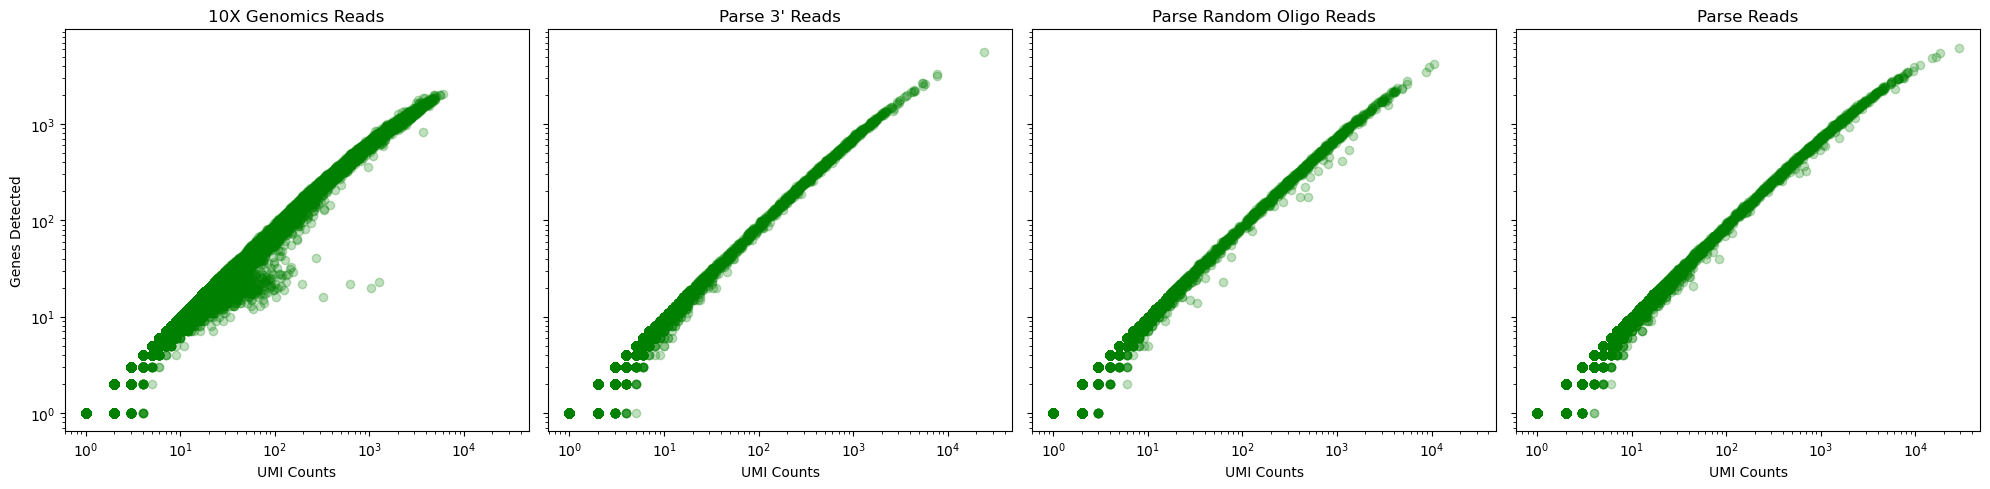

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(20,5), sharey=True,sharex=True)
scatter_reads(ax[0], data_10x, title='10X Genomics')
scatter_reads(ax[1], data_polyT, title="Parse 3'")
scatter_reads(ax[2], data_randO, title="Parse Random Oligo")
scatter_reads(ax[3], data_parse, title="Parse")

ax[0].set_ylabel("Genes Detected")

plt.tight_layout()
plt.show()


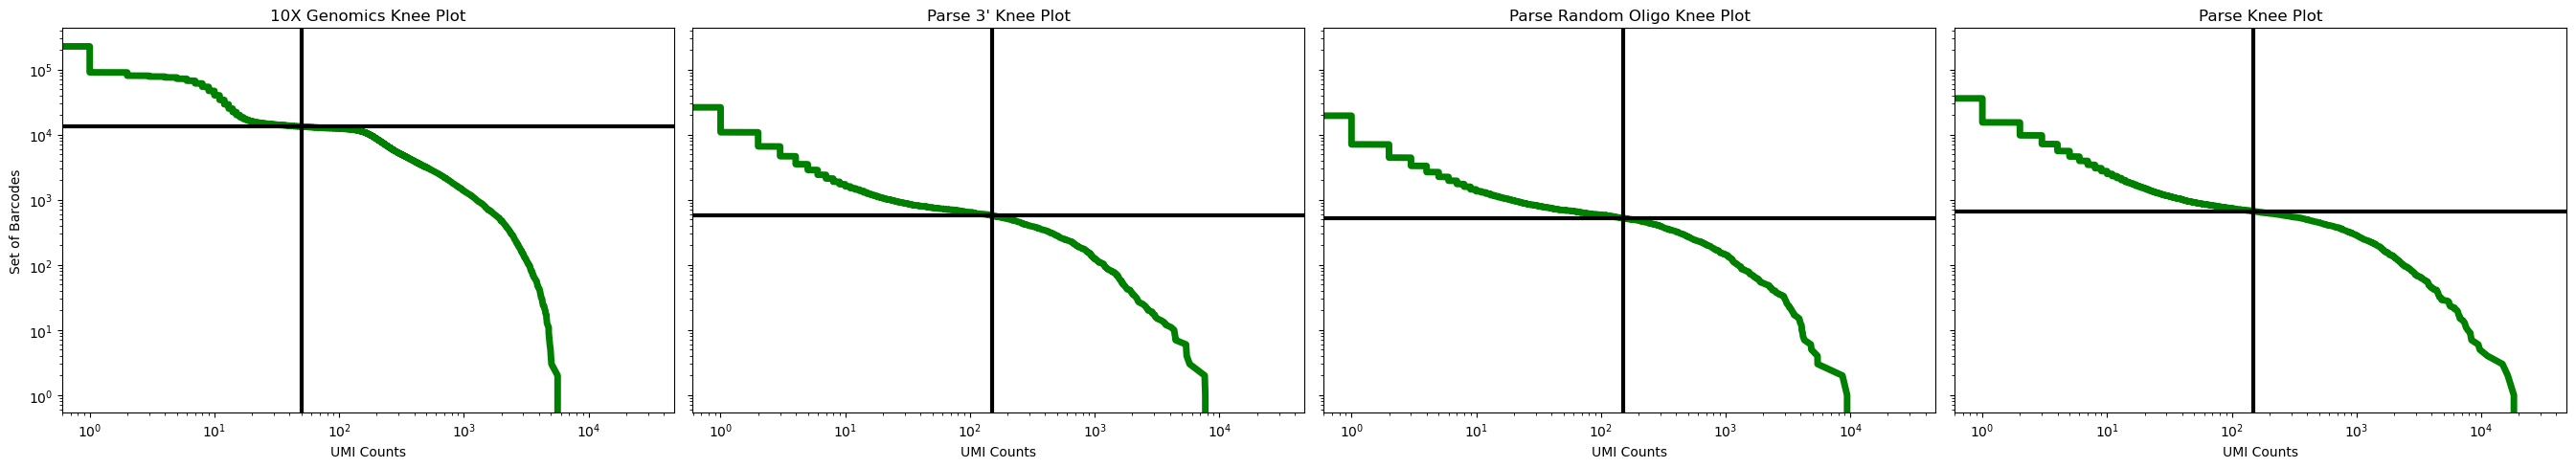

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(27,5), sharey=True,sharex=True)
knee_plot(ax[0], data_10x, title='10X Genomics', cutoff=50)
knee_plot(ax[1], data_polyT, title="Parse 3'", cutoff = 150)
knee_plot(ax[2], data_randO, title="Parse Random Oligo", cutoff=150)
knee_plot(ax[3], data_parse, title="Parse", cutoff=150)

ax[0].set_ylabel("Set of Barcodes")

plt.tight_layout()
plt.show()

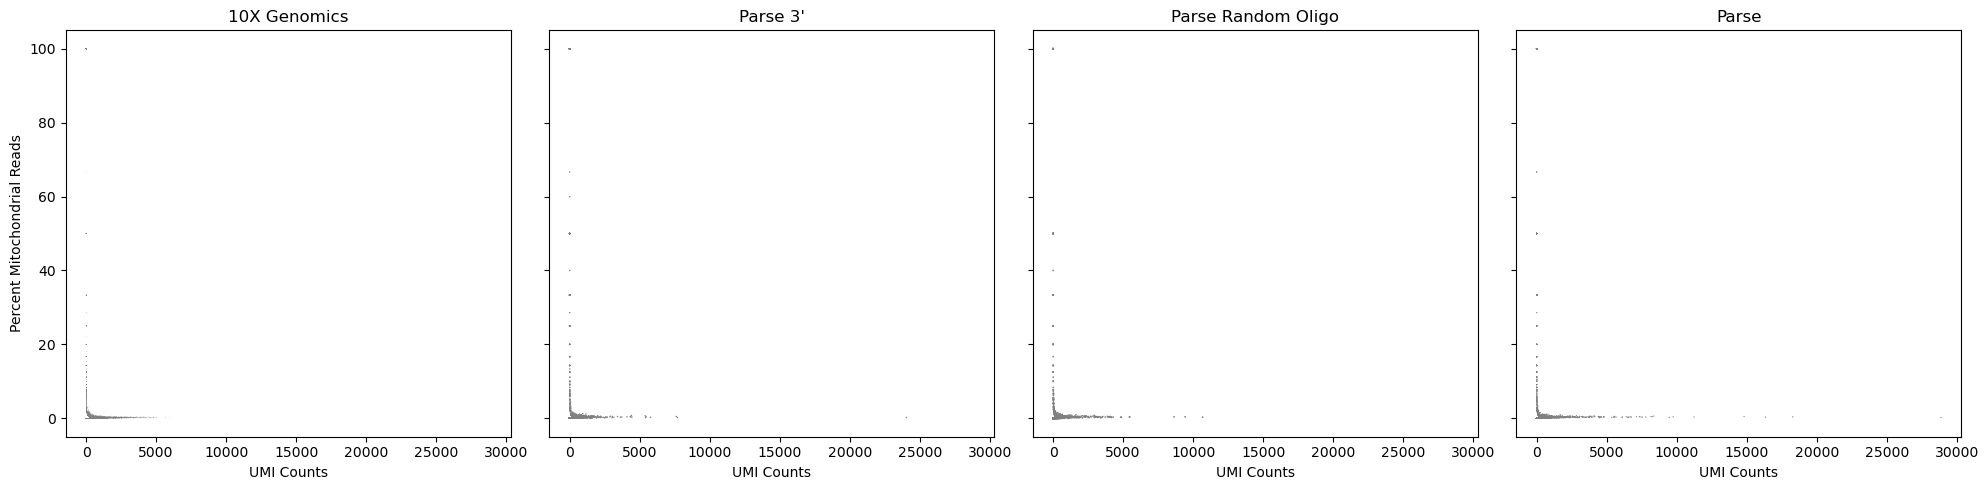

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(20,5), sharey=True,sharex=True)
mito_scatter(ax[0], data_10x, title='10X Genomics')
mito_scatter(ax[1], data_polyT, title="Parse 3'")
mito_scatter(ax[2], data_randO, title="Parse Random Oligo")
mito_scatter(ax[3], data_parse, title="Parse")

ax[0].set_ylabel("Percent Mitochondrial Reads")

plt.tight_layout()
plt.show()

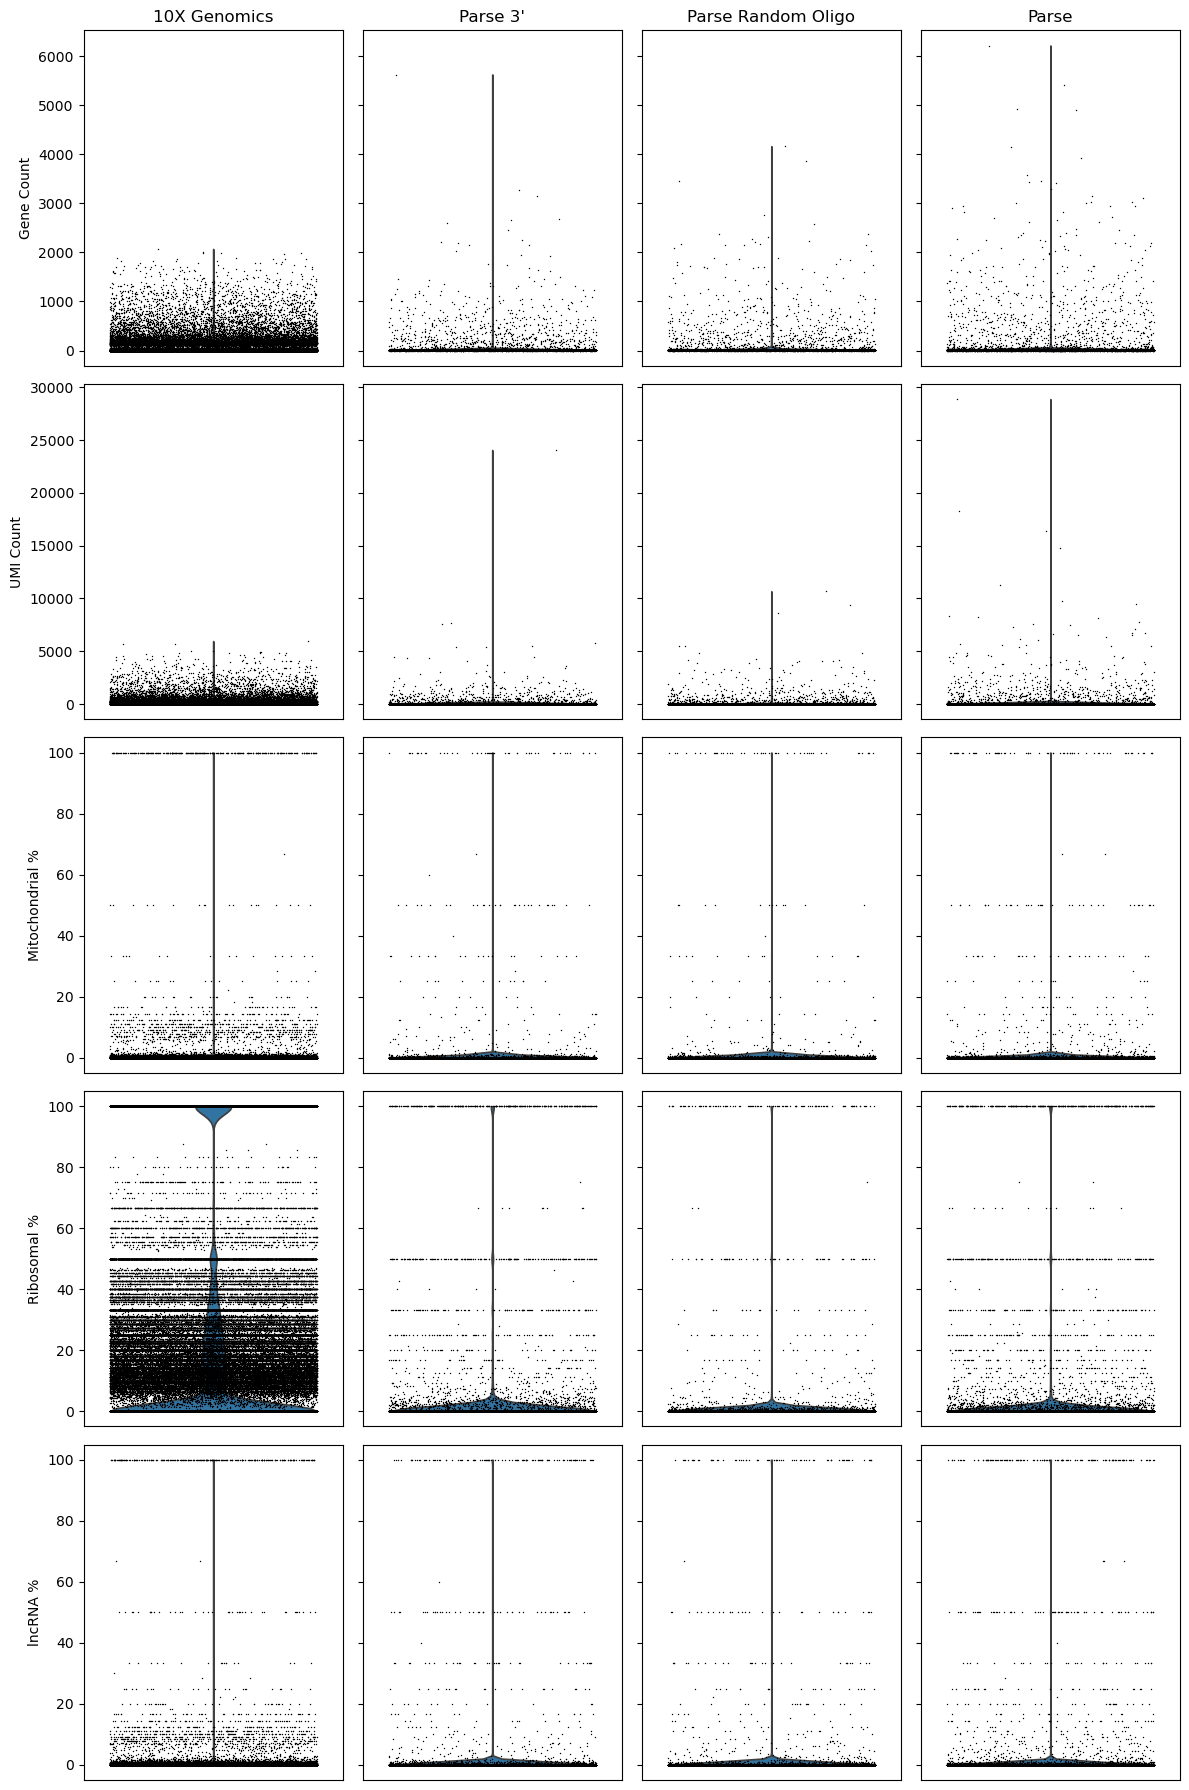

In [12]:
groups = ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_lnc']
group_names = ['Gene Count', 'UMI Count', 'Mitochondrial %', 'Ribosomal %', 'lncRNA %']
methods = ['10X Genomics', 'Parse 3\'', 'Parse Random Oligo', 'Parse']

fig, ax = plt.subplots(len(groups), 4, figsize=(12,18), sharey='row')
violin_plots(ax[:, 0], data_10x, groups)
violin_plots(ax[:, 1], data_polyT, groups)
violin_plots(ax[:, 2], data_randO, groups)
violin_plots(ax[:, 3], data_parse, groups)

for i, group in enumerate(group_names):
    ax[i,0].set_ylabel(group)

for i, method in enumerate(methods):
    ax[0,i].set_title(method)

plt.tight_layout()
plt.show()

# Read/Gene Comparisons

In [13]:
def top_gene_counts(ax, data, name = 'scRNA-seq'):
    genes = data.var
    top_genes = genes.sort_values(by='n_cells',ascending=False).head(10).index

    gene_dist = []
    for gene in top_genes:
        gene_dist.append(np.nan_to_num(data[:,gene].X.toarray().transpose()[0] / np.array(data.obs['n_counts'].tolist()) * 100))

    ax.violinplot(gene_dist, showmeans=True)
    ax.set_xticks(np.arange(1, len(top_genes) + 1), top_genes)
    ax.set_ylabel("")
    ax.set_title(name + " Top 10 Genes by Cell Count")

def compare_genes(data_x, data_y, x_name = 'x', y_name = 'y'):
    shared_genes = list(set(data_y.var_names).intersection(set(data_x.var_names)))
    shared_data = data_x.var.loc[shared_genes, 'percent_counts'].copy().to_frame()
    shared_data.rename(columns={'percent_counts': x_name + '_percent_counts'}, inplace=True)
    shared_data[y_name + '_percent_counts'] = data_y.var.loc[shared_genes, 'percent_counts'].values
    shared_data.sort_values(by=x_name + '_percent_counts', inplace=True)

    #fit linear regression model
    model = sm.OLS(shared_data[y_name + '_percent_counts'], shared_data[x_name + '_percent_counts']).fit() 
    np.set_printoptions(suppress=True) # suppress scientific notation
    shared_data['cooks_distance'] = model.get_influence().cooks_distance[0] + 1e-10  # add small value to avoid log(0) issues

    return shared_data

def scatter_genes(ax, shared_data, x_name = 'x', y_name = 'y',  xlim = None, ylim = None, norm = "log"):
    #Calculate correlation
    pearson_r = pearsonr(shared_data[x_name + '_percent_counts'], shared_data[y_name + '_percent_counts']).correlation
    spearman_r = spearmanr(shared_data[x_name + '_percent_counts'], shared_data[y_name + '_percent_counts']).correlation
    
    x_mean = shared_data[x_name + '_percent_counts'].mean()
    y_mean = shared_data[y_name + '_percent_counts'].mean()
    x_std = shared_data[x_name + '_percent_counts'].std()
    y_std = shared_data[y_name + '_percent_counts'].std()
    CCC_r = 2 * pearson_r * x_std * y_std / (x_std**2 + y_std**2 + (x_mean - y_mean)**2)

    plot = ax.scatter(shared_data[x_name + '_percent_counts'], 
                shared_data[y_name + '_percent_counts'], 
                norm = norm, 
                alpha=0.5, 
                s=50, 
                c=shared_data['cooks_distance'], 
                cmap='viridis')
    
    ax.set_xlabel(x_name + ' Gene Percent Count')
    ax.set_ylabel(y_name + ' Gene Percent Count')
    if xlim:
        ax.set_xlim(0, xlim)
    if ylim:
        ax.set_ylim(0, ylim)

    textstr = '\n'.join((
    r'$\mathrm{r}=%.2f$' % (pearson_r, ),
    r'$\rho=%.2f$' % (spearman_r, ),
    r'$\rho_C=%.2f$' % (CCC_r, ),))
    ax.text(0.05, 0.85, textstr, transform = ax.transAxes, fontsize = 12)

    return plot

/var/folders/lj/692w1y611fg61r1wpr5shd0c0000gn/T/ipykernel_3094/886610835.py:7: RuntimeWarning: invalid value encountered in divide
  gene_dist.append(np.nan_to_num(data[:,gene].X.toarray().transpose()[0] / np.array(data.obs['n_counts'].tolist()) * 100))
/var/folders/lj/692w1y611fg61r1wpr5shd0c0000gn/T/ipykernel_3094/886610835.py:7: RuntimeWarning: invalid value encountered in divide
  gene_dist.append(np.nan_to_num(data[:,gene].X.toarray().transpose()[0] / np.array(data.obs['n_counts'].tolist()) * 100))
/var/folders/lj/692w1y611fg61r1wpr5shd0c0000gn/T/ipykernel_3094/886610835.py:7: RuntimeWarning: invalid value encountered in divide
  gene_dist.append(np.nan_to_num(data[:,gene].X.toarray().transpose()[0] / np.array(data.obs['n_counts'].tolist()) * 100))
/var/folders/lj/692w1y611fg61r1wpr5shd0c0000gn/T/ipykernel_3094/886610835.py:7: RuntimeWarning: invalid value encountered in divide
  gene_dist.append(np.nan_to_num(data[:,gene].X.toarray().transpose()[0] / np.array(data.obs['n_counts'

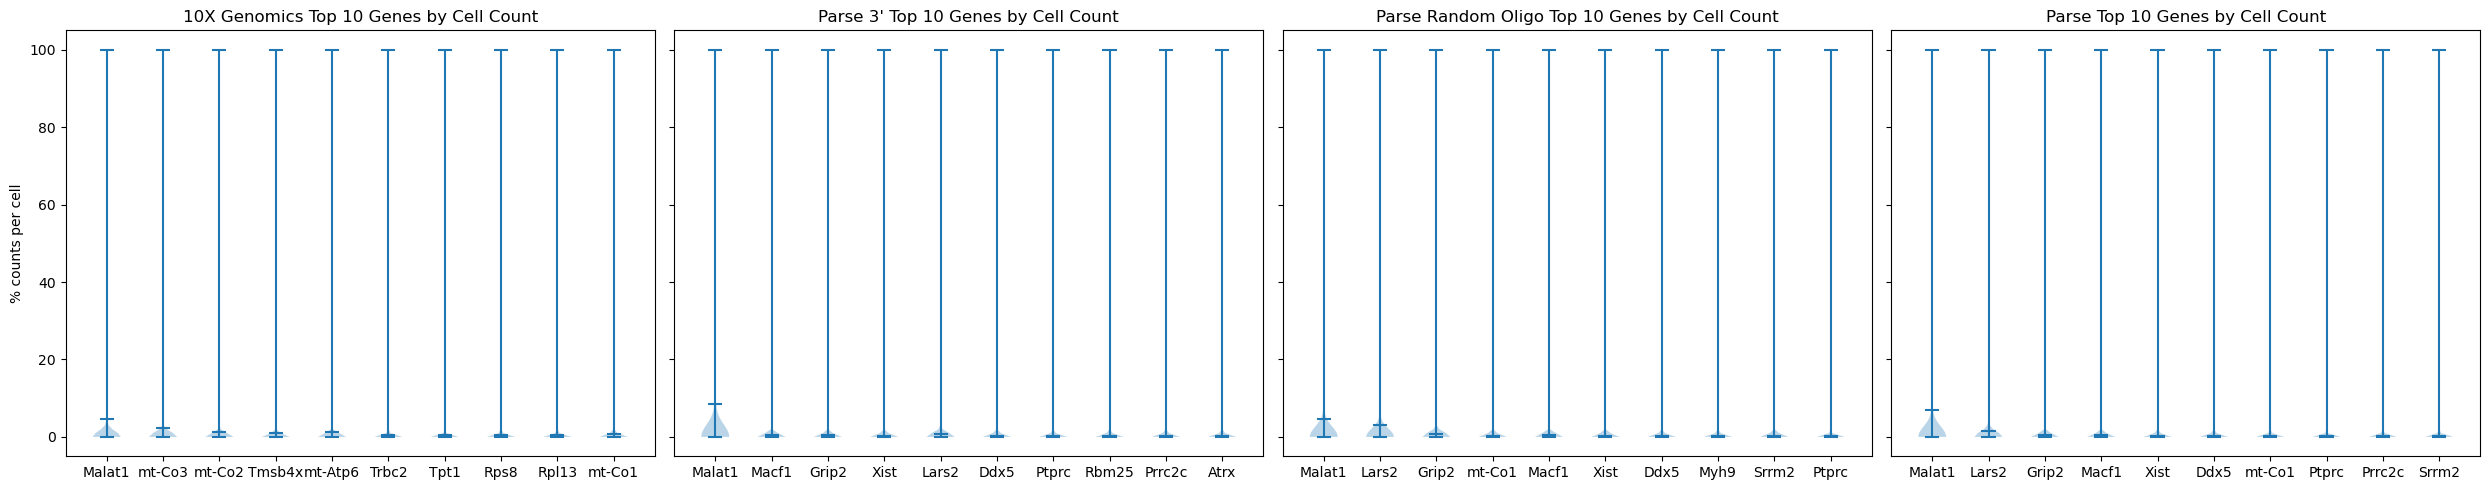

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(25,5), sharey=True)
top_gene_counts(ax[0], data_10x, name = '10X Genomics')
top_gene_counts(ax[1], data_polyT, name = "Parse 3'")
top_gene_counts(ax[2], data_randO, name = "Parse Random Oligo")
top_gene_counts(ax[3], data_parse, name = "Parse")

ax[0].set_ylabel("% counts per cell")

plt.tight_layout()
plt.show()

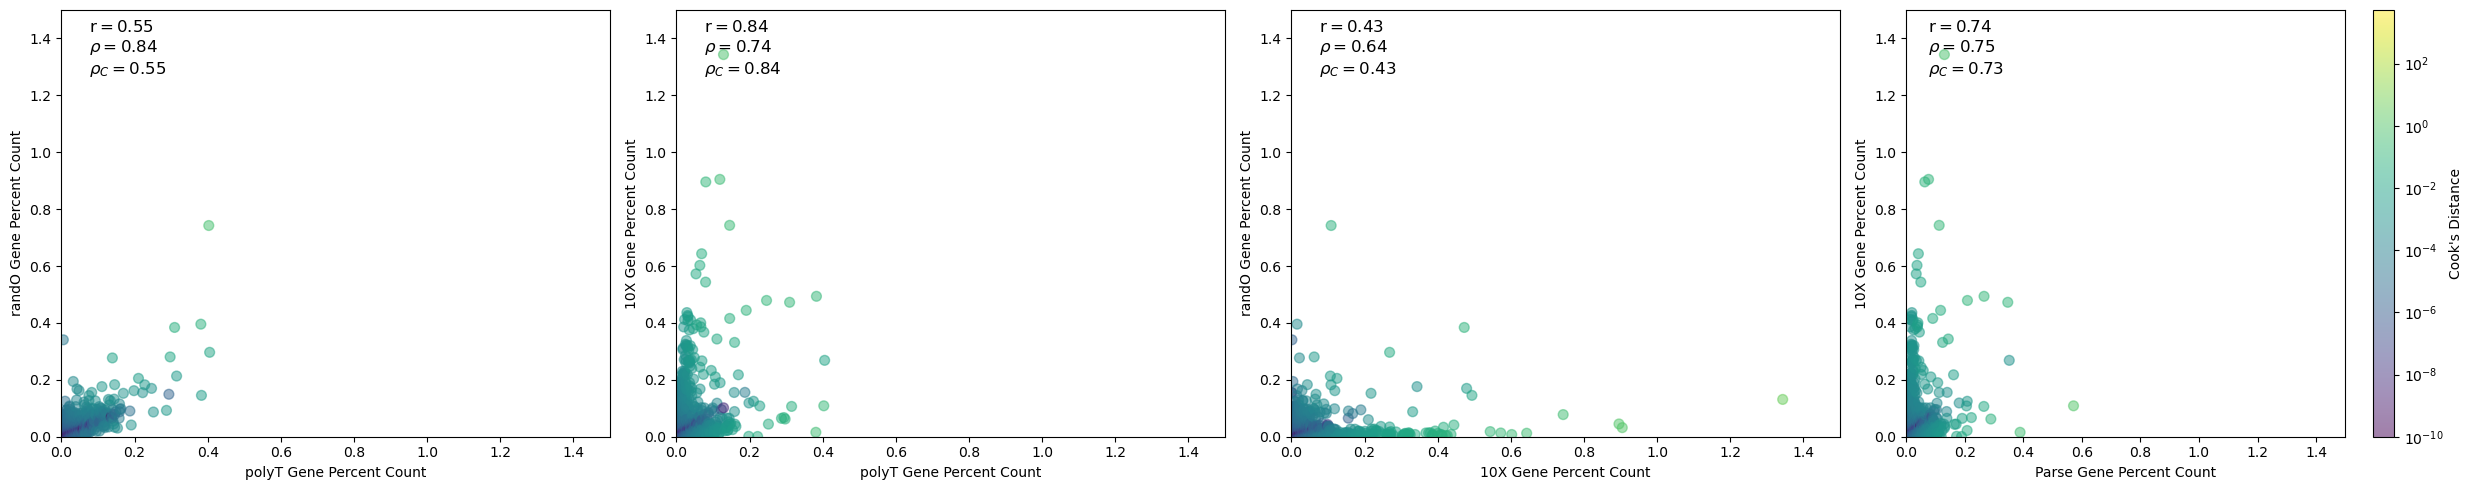

In [17]:
fig, axs = plt.subplots(1, 4, figsize = (25, 5))

xlim = 1.5
ylim = 1.5

TvO_genes = compare_genes(data_polyT, data_randO, x_name = 'polyT', y_name = 'randO')
TvX_genes = compare_genes(data_polyT, data_10x, x_name = 'polyT', y_name = '10X')
XvO_genes = compare_genes(data_10x, data_randO, x_name = '10X', y_name = 'randO')
PvX_genes = compare_genes(data_parse, data_10x, x_name = 'Parse', y_name = '10X')

c_values = TvO_genes['cooks_distance'].tolist() + TvX_genes['cooks_distance'].tolist() + XvO_genes['cooks_distance'].tolist()
norm = LogNorm(min(c_values), max(c_values))

scatter_genes(axs[0], TvO_genes, x_name = 'polyT', y_name = 'randO', xlim=xlim, ylim=ylim, norm=norm)
scatter_genes(axs[1], TvX_genes, x_name = 'polyT', y_name = '10X', xlim=xlim, ylim=ylim,norm=norm)
scatter_genes(axs[2], XvO_genes, x_name = '10X', y_name = 'randO', xlim=xlim, ylim=ylim,norm=norm)
plot = scatter_genes(axs[3], PvX_genes, x_name = 'Parse', y_name = '10X', xlim=xlim, ylim=ylim,norm=norm)

fig.colorbar(plot, label = "Cook's Distance")

plt.tight_layout()
plt.show()

In [18]:
for shared_data, string in zip([TvO_genes, TvX_genes, XvO_genes, PvX_genes], ("polyT vs randO", "polyT vs 10X", "10X vs randO", "Parse vs 10X")):
    shared_data.sort_values(by='cooks_distance', ascending=False, inplace=True)
    print("Top 10 outliers based on Cook's distance for", string, ":",  shared_data.index[:10].tolist())

Top 10 outliers based on Cook's distance for polyT vs randO : ['Malat1', 'Lars2', 'Grip2', 'Macf1', 'mt-Co1', 'Ddx5', 'Xist', 'Myh9', 'Srrm2', 'Ptma']
Top 10 outliers based on Cook's distance for polyT vs 10X : ['Malat1', 'mt-Co3', 'Macf1', 'Tmsb4x', 'mt-Atp6', 'Grip2', 'Ptma', 'mt-Co1', 'Actb', 'mt-Co2']
Top 10 outliers based on Cook's distance for 10X vs randO : ['Malat1', 'mt-Co3', 'Tmsb4x', 'mt-Co2', 'mt-Atp6', 'Rps8', 'Rpl13', 'Trbc2', 'Tpt1', 'mt-Co1']
Top 10 outliers based on Cook's distance for Parse vs 10X : ['Malat1', 'Lars2', 'Grip2', 'mt-Co3', 'Macf1', 'Ptma', 'mt-Atp6', 'mt-Co1', 'Actb', 'Tmsb4x']


In [37]:
genes_10x = data_10x.var
top_10x = genes_10x.sort_values(by='n_cells',ascending=False).head(10).index.tolist()

genes_polyT = data_polyT.var
top_polyT = genes_polyT.sort_values(by='n_cells',ascending=False).head(10).index.tolist()

print("Top 10 genes in 10x data:")
print(top_10x)
print()
print("Top 10 genes in parse data:")
print(top_polyT)

Top 10 genes in 10x data:
['Malat1', 'mt-Co3', 'mt-Co2', 'Tmsb4x', 'mt-Atp6', 'Trbc2', 'Tpt1', 'Rps8', 'Rpl13', 'mt-Co1']

Top 10 genes in parse data:
['Malat1', 'Macf1', 'Grip2', 'Xist', 'Lars2', 'Ddx5', 'Ptprc', 'Rbm25', 'Prrc2c', 'Atrx']


In [38]:
common_genes = data_10x.var_names.intersection(data_polyT.var_names)
print("num common genes: " + str(common_genes.shape[0]))
print("num 10x genes: " + str(data_10x.var_names.shape[0]))
print("num parse genes: " + str(data_polyT.var_names.shape[0]))

num common genes: 12842
num 10x genes: 17099
num parse genes: 13910


In [39]:
top_thousand_10x = genes_10x.sort_values(by='n_cells',ascending=False).head(1000)
top_thousand_polyT = genes_polyT.sort_values(by='n_cells',ascending=False).head(1000)

print("Number of shared genes from top 1000 genes for each method: " + str(len(top_thousand_10x.index.intersection(top_thousand_polyT.index))))

Number of shared genes from top 1000 genes for each method: 425
